# Import Library

In [118]:
# !pip install scikit-learn==1.2.2

In [119]:
import sklearn
print(sklearn.__version__)

1.2.2


In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import regex as re
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler

# Import Dataset

In [121]:
df = pd.read_csv("data_perhari_new.csv")
df_test = pd.read_csv("datatest_perhari.csv")

df

,TANGGAL,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR
0,1/1/2019,26.4,33.8,29.5,73,-,1.3,7,340,3,NW
1,2/1/2019,26.8,34.8,29.2,75,0,0,4,270,2,W
2,3/1/2019,25.2,31.7,27.2,86,20.5,5.9,5,340,2,C
3,4/1/2019,24.8,32.1,28,82,2.6,0,4,10,2,N
4,5/1/2019,25,33.4,29.7,77,0.9,4.5,4,340,2,N
...,...,...,...,...,...,...,...,...,...,...,...
2189,27/12/2024,27,33.8,30.2,68,0.4,3.5,5,320,2,NW
2190,28/12/2024,28.2,34.2,29,77,0,5.8,5,300,2,NW
2191,29/12/2024,25.4,31.9,28.1,79,12.7,2.5,5,300,2,W
2192,30/12/2024,26,34.2,29.7,69,0,0.8,5,330,3,NW


In [122]:
df_test

,TANGGAL,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR
0,1/1/2025,26.2,31.8,28.0,82,8.5,2.0,4,320,2,NW
1,2/1/2025,25.0,32.4,27.1,89,36.2,0.0,4,340,1,N
2,3/1/2025,25.6,34.6,29.3,74,0.6,1.4,3,300,2,NW
3,4/1/2025,26.0,33.8,29.2,73,0.0,7.5,6,350,3,NW
4,5/1/2025,25.9,33.8,27.8,81,6.8,3.8,6,310,2,S
...,...,...,...,...,...,...,...,...,...,...,...
77,19/3/2025,26.2,32.9,28.2,80,8.0,5.3,8,310,2,NW
78,20/3/2025,25.8,35.6,29.7,75,12.3,3.5,6,310,3,NW
79,21/3/2025,26.4,34.9,28.6,77,0.8,5.9,9,300,5,NW
80,22/3/2025,25.0,33.0,28.5,82,17.2,6.4,7,330,4,NW


In [123]:
df = df.drop(columns=['TANGGAL'])
df_test = df_test.drop(columns=['TANGGAL'])

In [124]:
df.dtypes

TN         object
TX         object
TAVG       object
RH_AVG     object
RR         object
SS         object
FF_X        int64
DDD_X       int64
FF_AVG      int64
DDD_CAR    object
dtype: object

# Normalisasi Data

## Encoding RR

In [125]:
# Mengubah nilai '-' dan '9999' menjadi 0
df['RR'].replace(['-', '9999'], 0, inplace=True)
df['RR'].replace(['8888'], 0.1, inplace=True)

# Data Test
df_test['RR'].replace(['-', '9999'], 0, inplace=True)
df_test['RR'].replace(['8888'], 0.1, inplace=True)

print(df)

        TN    TX  TAVG RH_AVG    RR   SS  FF_X  DDD_X  FF_AVG DDD_CAR
0     26.4  33.8  29.5     73     0  1.3     7    340       3      NW
1     26.8  34.8  29.2     75     0    0     4    270       2      W 
2     25.2  31.7  27.2     86  20.5  5.9     5    340       2      C 
3     24.8  32.1    28     82   2.6    0     4     10       2      N 
4       25  33.4  29.7     77   0.9  4.5     4    340       2      N 
...    ...   ...   ...    ...   ...  ...   ...    ...     ...     ...
2189    27  33.8  30.2     68   0.4  3.5     5    320       2      NW
2190  28.2  34.2    29     77     0  5.8     5    300       2      NW
2191  25.4  31.9  28.1     79  12.7  2.5     5    300       2       W
2192    26  34.2  29.7     69     0  0.8     5    330       3      NW
2193  25.6  32.8  28.2     79     1  5.5     6    300       3      NW

[2194 rows x 10 columns]


## Encoding DDD_CAR

In [126]:
df['DDD_CAR'] = df['DDD_CAR'].str.strip()

df['DDD_CAR'].value_counts()

DDD_CAR
SE    984
NW    420
E     191
N     154
S     154
C     149
W      97
NE     45
Name: count, dtype: int64

In [127]:
def get_wind_direction(degrees):
    try:
        degrees = float(degrees)  # Konversi ke float untuk menghindari TypeError
        directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
        index = int((degrees + 22.5) // 45) % 8  # Geser +22.5 untuk pembagian rentang
        return directions[index]
    except ValueError:
        return "Invalid"  # Handle jika ada nilai yang tidak bisa dikonversi ke float

# Data Train
df['DDD_CAR_new'] = df['DDD_X'].apply(get_wind_direction)

df.loc[df['DDD_CAR'] == 'C', 'DDD_CAR'] = df['DDD_CAR_new']
df[:30]

# Data Test
df_test['DDD_CAR_new'] = df_test['DDD_X'].apply(get_wind_direction)

df_test.loc[df_test['DDD_CAR'] == 'C', 'DDD_CAR'] = df_test['DDD_CAR_new']
# df_test[:30]

In [128]:
df = df.drop(columns=['DDD_CAR_new'])
df_test = df_test.drop(columns=['DDD_CAR_new'])

df

,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR
0,26.4,33.8,29.5,73,0,1.3,7,340,3,NW
1,26.8,34.8,29.2,75,0,0,4,270,2,W
2,25.2,31.7,27.2,86,20.5,5.9,5,340,2,N
3,24.8,32.1,28,82,2.6,0,4,10,2,N
4,25,33.4,29.7,77,0.9,4.5,4,340,2,N
...,...,...,...,...,...,...,...,...,...,...
2189,27,33.8,30.2,68,0.4,3.5,5,320,2,NW
2190,28.2,34.2,29,77,0,5.8,5,300,2,NW
2191,25.4,31.9,28.1,79,12.7,2.5,5,300,2,W
2192,26,34.2,29.7,69,0,0.8,5,330,3,NW


In [129]:
# Mapping manual untuk arah mata angin
arah_angin_mapping = {
    "N": 1,
    "NE": 2,
    "E": 3,
    "SE": 4,
    "S": 5,
    "SW": 6,
    "W": 7,
    "NW": 8
}


In [130]:
# Mapping arah angin ke dataset df dan df_test
df['DDD_CAR'] = df['DDD_CAR'].str.strip().map(arah_angin_mapping)
df_test['DDD_CAR'] = df_test['DDD_CAR'].str.strip().map(arah_angin_mapping)

## Encoding DDD_X

In [131]:
# Encoding arah angin dalam bentuk sin dan cos untuk menangani sifat sirkularnya
df['DDD_X'] = np.deg2rad(df['DDD_X'])
df_test['DDD_X'] = np.deg2rad(df_test['DDD_X'])

df

,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR
0,26.4,33.8,29.5,73,0,1.3,7,5.934119,3,8
1,26.8,34.8,29.2,75,0,0,4,4.712389,2,7
2,25.2,31.7,27.2,86,20.5,5.9,5,5.934119,2,1
3,24.8,32.1,28,82,2.6,0,4,0.174533,2,1
4,25,33.4,29.7,77,0.9,4.5,4,5.934119,2,1
...,...,...,...,...,...,...,...,...,...,...
2189,27,33.8,30.2,68,0.4,3.5,5,5.585054,2,8
2190,28.2,34.2,29,77,0,5.8,5,5.235988,2,8
2191,25.4,31.9,28.1,79,12.7,2.5,5,5.235988,2,7
2192,26,34.2,29.7,69,0,0.8,5,5.759587,3,8


## Drop NA

In [132]:
df[df.eq('-').any(axis=1)]

,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR
24,-,32,28.2,80,16,4,6,5.759587,3,8
487,-,33.4,29.2,80,2.7,8.2,4,1.221730,2,3
667,-,-,-,86,0,6.2,3,2.268928,1,4
902,-,33.4,28.4,80,0.8,4.6,4,2.094395,2,4
1087,-,-,-,90,0.9,4,6,5.235988,2,4
1140,-,32.7,28.4,79,1.1,0.3,6,5.235988,3,8
1198,-,35.1,29.4,77,0,6.1,5,2.094395,2,3
1218,-,34.4,29.4,82,6.7,2.9,7,2.268928,3,4
1219,26.4,-,30,76,0,6,5,2.792527,2,4
1235,-,33.2,28,85,2,6.8,6,1.396263,2,4


In [133]:
df = df[~df.eq('-').any(axis=1)]
df_test = df_test[~df_test.eq('-').any(axis=1)]

df

,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR
0,26.4,33.8,29.5,73,0,1.3,7,5.934119,3,8
1,26.8,34.8,29.2,75,0,0,4,4.712389,2,7
2,25.2,31.7,27.2,86,20.5,5.9,5,5.934119,2,1
3,24.8,32.1,28,82,2.6,0,4,0.174533,2,1
4,25,33.4,29.7,77,0.9,4.5,4,5.934119,2,1
...,...,...,...,...,...,...,...,...,...,...
2189,27,33.8,30.2,68,0.4,3.5,5,5.585054,2,8
2190,28.2,34.2,29,77,0,5.8,5,5.235988,2,8
2191,25.4,31.9,28.1,79,12.7,2.5,5,5.235988,2,7
2192,26,34.2,29.7,69,0,0.8,5,5.759587,3,8


In [134]:
df = df[~df.eq('9999').any(axis=1)]
df_test = df_test[~df_test.eq('9999').any(axis=1)]

In [135]:
df.isnull().sum()

TN         0
TX         0
TAVG       0
RH_AVG     0
RR         0
SS         0
FF_X       0
DDD_X      0
FF_AVG     0
DDD_CAR    0
dtype: int64

In [136]:
df_test.isnull().sum()

TN         0
TX         0
TAVG       0
RH_AVG     0
RR         0
SS         0
FF_X       0
DDD_X      0
FF_AVG     0
DDD_CAR    0
dtype: int64

In [137]:
# df = df[df.eq('-').any(axis=1)]

In [138]:
# df = df[df["SS"] == 9999]

In [139]:
# df[df.eq(9999).any(axis=1)]

## Change Data Type

In [140]:
df.dtypes

TN          object
TX          object
TAVG        object
RH_AVG      object
RR          object
SS          object
FF_X         int64
DDD_X      float64
FF_AVG       int64
DDD_CAR      int64
dtype: object

In [141]:
df = df.apply(pd.to_numeric, errors='coerce')
df_test = df_test.apply(pd.to_numeric, errors='coerce')

df.isnull().sum()

TN         0
TX         0
TAVG       0
RH_AVG     0
RR         0
SS         0
FF_X       0
DDD_X      0
FF_AVG     0
DDD_CAR    0
dtype: int64

In [142]:
df.dtypes

TN         float64
TX         float64
TAVG       float64
RH_AVG       int64
RR         float64
SS         float64
FF_X         int64
DDD_X      float64
FF_AVG       int64
DDD_CAR      int64
dtype: object

In [143]:
df_test.isnull().sum()

TN         0
TX         0
TAVG       0
RH_AVG     0
RR         0
SS         0
FF_X       0
DDD_X      0
FF_AVG     0
DDD_CAR    0
dtype: int64

In [144]:
df_test.dtypes

TN         float64
TX         float64
TAVG       float64
RH_AVG       int64
RR         float64
SS         float64
FF_X         int64
DDD_X      float64
FF_AVG       int64
DDD_CAR      int64
dtype: object

# EDA

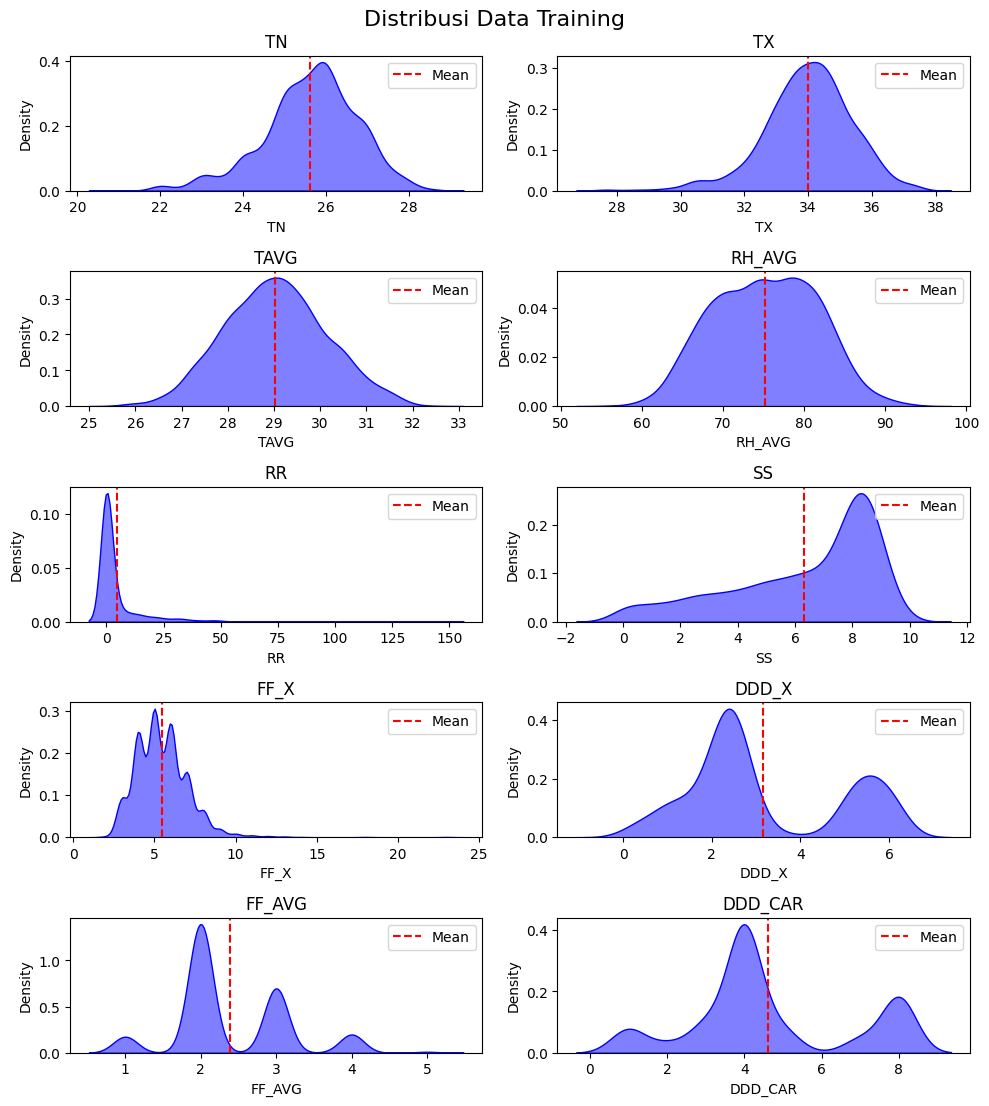

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pilih hanya kolom numerik
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

cols = len(num_cols)
rows = (cols + 2) // 2  # Menyesuaikan jumlah baris

plt.figure(figsize=(10, 13))
plt.suptitle('Distribusi Data Training', fontsize=16)

for i, col in enumerate(num_cols, 1):  
    plt.subplot(rows, 2, i)

    # Paksa semua kolom menggunakan density plot
    sns.kdeplot(df[col], fill=True, color='blue', alpha=0.5)
    plt.axvline(df[col].mean(), color='red', linestyle='--', label='Mean')
    plt.legend()

    plt.title(col)
    plt.xlabel(col)

plt.tight_layout()
plt.show()


In [146]:
# df.

## Boxplot

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20952\141805192.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(rows, 2, i)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python3

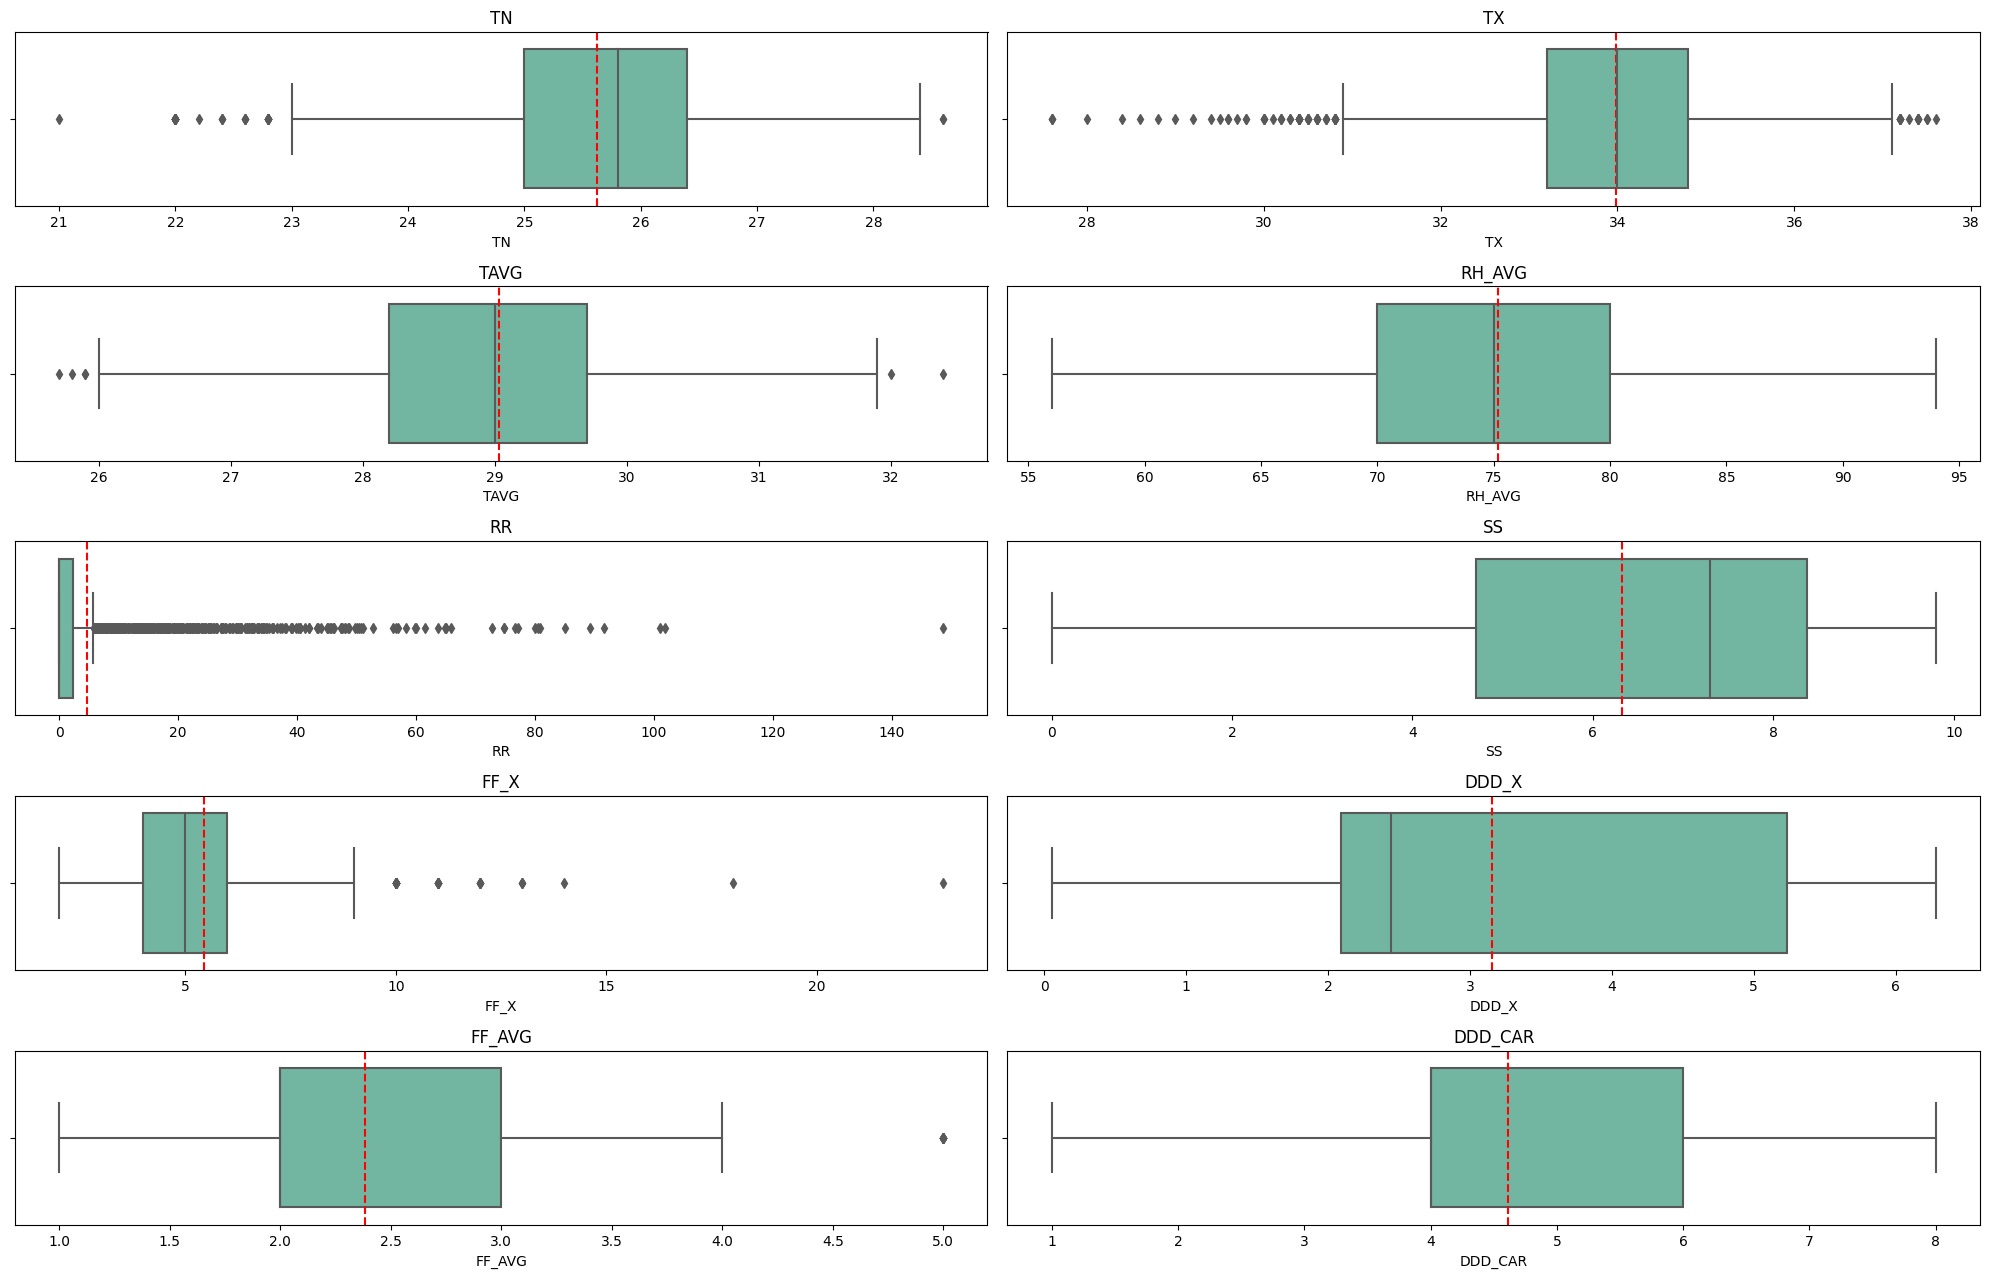

In [147]:
num_cols = df.select_dtypes(include=['Float64', 'int32', 'int64']).columns

cols = len(num_cols)
rows = (cols + 2) // 2

plt.figure(figsize=(20, 15))
plt.title('Data Training')

for i, col in enumerate(num_cols, 1): 
    plt.subplot(rows, 2, i) 
    sns.boxplot(x=df[col], orient='v', palette='Set2')
    plt.axvline(df[col].mean(), color='red', linestyle='--', label='Mean')
    plt.title(col)
    plt.tight_layout()

plt.show() # code untuk menampilkan visualisasi

## Heatmap Correlation

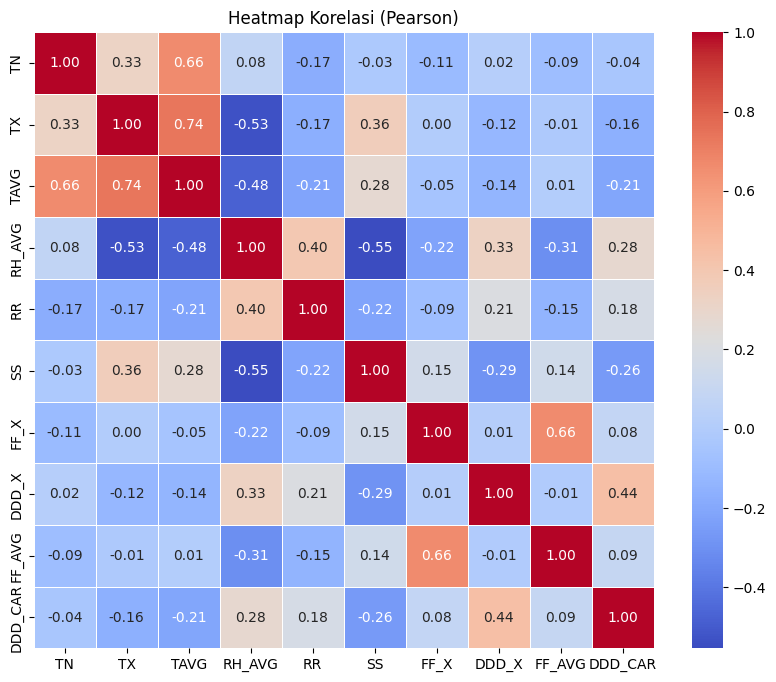

               TN        TX      TAVG    RH_AVG        RR        SS      FF_X   
TN       1.000000  0.325489  0.661764  0.075107 -0.172138 -0.025362 -0.105387  \
TX       0.325489  1.000000  0.738408 -0.534900 -0.170580  0.362053  0.000938   
TAVG     0.661764  0.738408  1.000000 -0.476933 -0.214953  0.277060 -0.053550   
RH_AVG   0.075107 -0.534900 -0.476933  1.000000  0.395860 -0.553510 -0.221866   
RR      -0.172138 -0.170580 -0.214953  0.395860  1.000000 -0.217685 -0.090499   
SS      -0.025362  0.362053  0.277060 -0.553510 -0.217685  1.000000  0.151624   
FF_X    -0.105387  0.000938 -0.053550 -0.221866 -0.090499  0.151624  1.000000   
DDD_X    0.016961 -0.124413 -0.137943  0.326448  0.209405 -0.291178  0.011671   
FF_AVG  -0.086359 -0.013695  0.005392 -0.308817 -0.146375  0.144676  0.660821   
DDD_CAR -0.038769 -0.163147 -0.209359  0.278042  0.178667 -0.258832  0.080600   

            DDD_X    FF_AVG   DDD_CAR  
TN       0.016961 -0.086359 -0.038769  
TX      -0.124413 -0.013695 

In [148]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_matrix(df, method='pearson'):
    # Hitung matriks korelasi
    correlation_matrix = df.corr(method=method)

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title(f'Heatmap Korelasi ({method.title()})')
    plt.show()

    return correlation_matrix

correlation_matrix = plot_correlation_matrix(df)
print(correlation_matrix)


## Kategori Hujan

In [149]:
# df['RR'] = df['RR'].apply(
#     lambda x: 0 if x == 0 else # hujan sangat ringan
#               1 if 0 < x < 20 else # hujan ringan
#               2 if 20 <= x < 50 else # hujan sedang
#               3 if 50 <= x < 100 else  # hujan lebat
#             4 # hujan sangat lebat
# )

In [150]:
df['RR'] = df['RR'].apply(
    lambda x: 0 if x < 5 else # hujan sangat ringan
              1 if 5 <= x <= 20 else # hujan ringan
              2 if 20 < x <= 50 else # hujan sedang
              3 if 50 < x <= 100 else  # hujan lebat
            4 # hujan sangat lebat
)

In [151]:
df_test['RR'] = df_test['RR'].apply(
    lambda x: 0 if x < 5 else # hujan sangat ringan
              1 if 5 <= x <= 20 else # hujan ringan
              2 if 20 < x <= 50 else # hujan sedang
              3 if 50 < x <=  100 else  # hujan lebat
            4 # hujan sangat lebat
)

In [152]:
df['RR'].value_counts()

RR
0    1744
1     248
2     145
3      26
4       3
Name: count, dtype: int64

In [153]:
df_test['RR'].value_counts()

RR
0    40
1    20
2    11
4     9
3     2
Name: count, dtype: int64

In [154]:
df.

SyntaxError: invalid syntax (791285630.py, line 1)

# Klasifikasi

### Normalisasi

In [155]:
# Normalisasi Data
scaler_robust = RobustScaler()
df[['TN', 'TX', 'FF_X', 'FF_AVG']] = scaler_robust.fit_transform(df[['TN', 'TX', 'FF_X', 'FF_AVG']])
# df[['TAVG', 'FF_AVG']] = scaler_robust.fit_transform(df[['TAVG', 'FF_AVG']])

scaler_minmax = MinMaxScaler()
df[['RH_AVG', 'SS', 'DDD_X', 'TAVG']] = scaler_minmax.fit_transform(df[['RH_AVG', 'SS', 'DDD_X', 'TAVG']])

import joblib
joblib.dump(scaler_robust, "scaler_robust.pkl")
joblib.dump(scaler_minmax, "scaler_minmax.pkl")

['scaler_minmax.pkl']

In [156]:
# Normalisasi Data
scaler_robust = RobustScaler()
df_test[['TN', 'TX', 'TAVG', 'FF_X', 'FF_AVG']] = scaler_robust.fit_transform(df_test[['TN', 'TX', 'TAVG', 'FF_X', 'FF_AVG']])
# df_test[['TAVG', 'FF_AVG']] = scaler_robust.fit_transform(df_test[['TAVG', 'FF_AVG']])

scaler_minmax = MinMaxScaler()
df_test[['RH_AVG', 'SS', 'DDD_X']] = scaler_minmax.fit_transform(df_test[['RH_AVG', 'SS', 'DDD_X']])

### Split Dataset dan Normalisasi

In [157]:
# Pisahkan fitur (X) dan target (y)
X = df.drop(columns=['RR'])
y = df['RR']

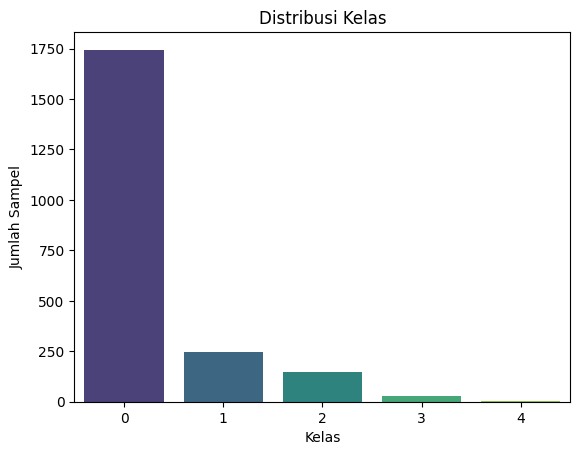

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

# Contoh variabel target y
sns.countplot(x=y, palette='viridis')
plt.title("Distribusi Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Sampel")
plt.show()


### Handling Imbalance Data

In [159]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Handling Imbalance Data dengan SMOTE
smote = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Melihat distribusi data sebelum dan sesudah oversampling
print("Distribusi Sebelum Oversampling:", np.bincount(y))
print("Distribusi Setelah Oversampling:", np.bincount(y_resampled))


Distribusi Sebelum Oversampling: [1744  248  145   26    3]
Distribusi Setelah Oversampling: [1744 1744 1744 1744 1744]


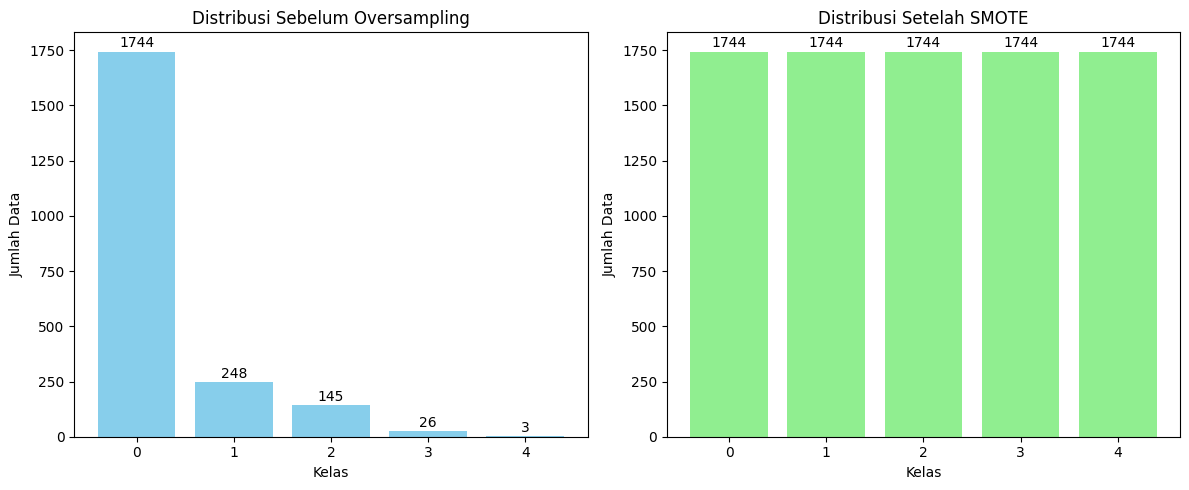

In [160]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np

# Oversampling dengan SMOTE
smote = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Distribusi sebelum dan sesudah
before_counts = np.bincount(y)
after_counts = np.bincount(y_resampled)

# Plot distribusi
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Sebelum SMOTE
axs[0].bar(range(len(before_counts)), before_counts, color='skyblue')
axs[0].set_title("Distribusi Sebelum Oversampling")
axs[0].set_xlabel("Kelas")
axs[0].set_ylabel("Jumlah Data")
for i, count in enumerate(before_counts):
    axs[0].text(i, count + 5, str(count), ha='center', va='bottom')

# Setelah SMOTE
axs[1].bar(range(len(after_counts)), after_counts, color='lightgreen')
axs[1].set_title("Distribusi Setelah SMOTE")
axs[1].set_xlabel("Kelas")
axs[1].set_ylabel("Jumlah Data")
for i, count in enumerate(after_counts):
    axs[1].text(i, count + 5, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()


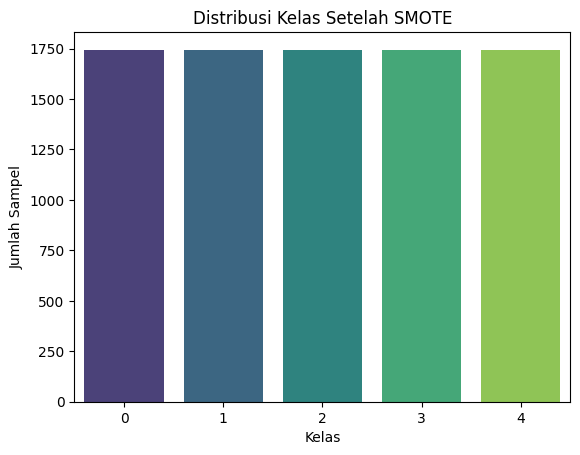

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

# Contoh variabel target y
sns.countplot(x=y_resampled, palette='viridis')
plt.title("Distribusi Kelas Setelah SMOTE")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Sampel")
plt.show()


## LR

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



📊 Evaluasi Model pada Validation Set:
📌 Akurasi: 0.6461

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.66      0.69       279
           1       0.54      0.50      0.52       280
           2       0.42      0.29      0.34       279
           3       0.62      0.79      0.69       279
           4       0.84      1.00      0.91       279

    accuracy                           0.65      1396
   macro avg       0.63      0.65      0.63      1396
weighted avg       0.63      0.65      0.63      1396



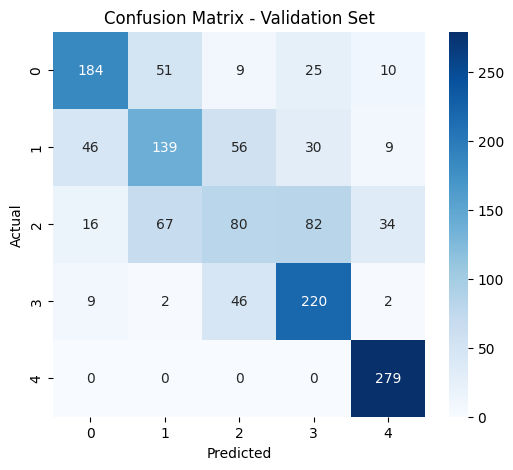


📊 Evaluasi Model pada Test Set:
📌 Akurasi: 0.6468

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.66      0.67       349
           1       0.47      0.44      0.45       348
           2       0.47      0.35      0.40       349
           3       0.66      0.79      0.72       349
           4       0.86      1.00      0.93       349

    accuracy                           0.65      1744
   macro avg       0.63      0.65      0.63      1744
weighted avg       0.63      0.65      0.63      1744



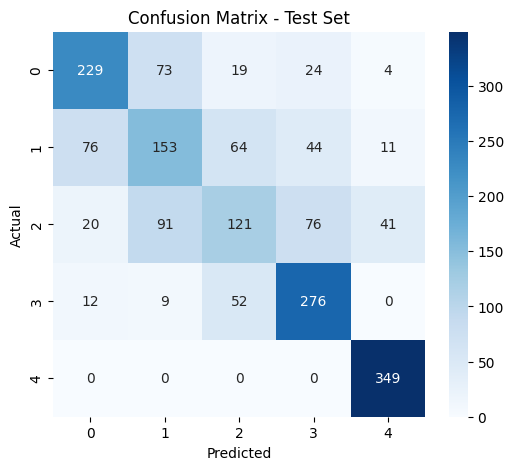

In [162]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 📌 1️⃣ Membagi data menjadi Train (64%), Test (20%), Validation (16%)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=123)

# Inisiasi Model Logistic Regression
logreg_model = LogisticRegression(random_state=123)
logreg_model.fit(X_train, y_train)

# ==== Evaluasi Model Data Validation ====
y_pred_val = logreg_model.predict(X_val)
print("\n📊 Evaluasi Model pada Validation Set:")
print(f"📌 Akurasi: {accuracy_score(y_val, y_pred_val):.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))

# Confusion Matrix (Validation Set)
cm_val = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Validation Set")
plt.show()

# === Evaluasi Model Data Test ===
y_pred = logreg_model.predict(X_test)
print("\n📊 Evaluasi Model pada Test Set:")
print(f"📌 Akurasi: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix (Test Set)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.show()


## SVM

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



📊 Evaluasi Model pada Validation Set:
📌 Akurasi: 0.6655

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.79      0.74       279
           1       0.55      0.56      0.55       280
           2       0.41      0.15      0.22       279
           3       0.65      0.83      0.73       279
           4       0.83      1.00      0.91       279

    accuracy                           0.67      1396
   macro avg       0.63      0.67      0.63      1396
weighted avg       0.63      0.67      0.63      1396



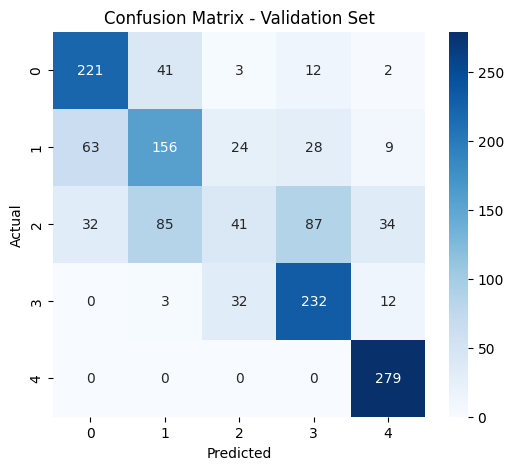


📊 Evaluasi Model pada Test Set:
📌 Akurasi: 0.6439

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.71      0.68       349
           1       0.48      0.45      0.47       348
           2       0.46      0.21      0.29       349
           3       0.62      0.85      0.71       349
           4       0.86      1.00      0.93       349

    accuracy                           0.64      1744
   macro avg       0.62      0.64      0.62      1744
weighted avg       0.62      0.64      0.62      1744



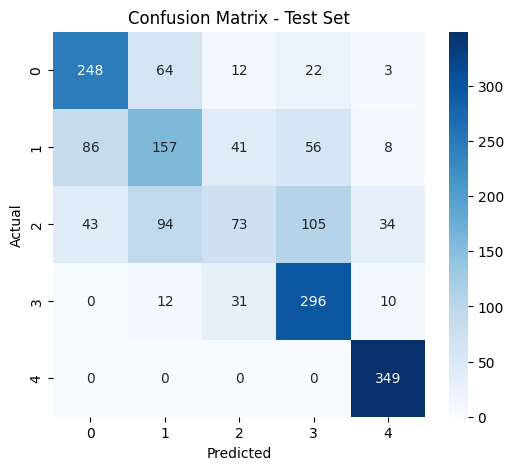

In [163]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 📌 1️⃣ Membagi data menjadi Train (64%), Test (20%), Validation (16%)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=123)

# Inisiasi Model SVM
svm_model = LinearSVC(random_state=123)
svm_model.fit(X_train, y_train)

# ==== Evaluasi Model Data Validation ====
y_pred_val = svm_model.predict(X_val)
print("\n📊 Evaluasi Model pada Validation Set:")
print(f"📌 Akurasi: {accuracy_score(y_val, y_pred_val):.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))

# Confusion Matrix (Validation Set)
cm_val = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Validation Set")
plt.show()

# === Evaluasi Model Data Test ===
y_pred = svm_model.predict(X_test)
print("\n📊 Evaluasi Model pada Test Set:")
print(f"📌 Akurasi: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix (Test Set)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.show()


## NB


📊 Evaluasi Model pada Validation Set:
📌 Akurasi: 0.6633

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.71      0.74       279
           1       0.47      0.37      0.42       280
           2       0.43      0.40      0.41       279
           3       0.66      0.83      0.74       279
           4       0.92      1.00      0.96       279

    accuracy                           0.66      1396
   macro avg       0.65      0.66      0.65      1396
weighted avg       0.65      0.66      0.65      1396



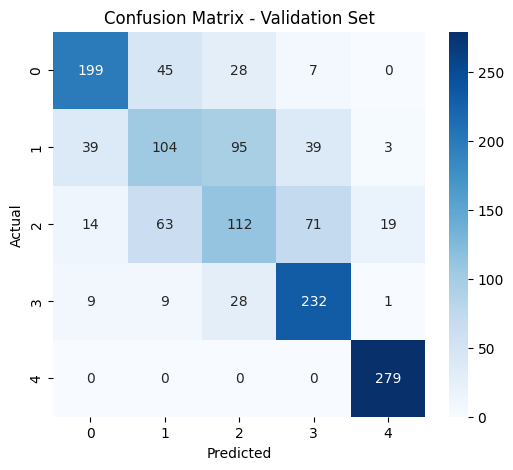


📊 Evaluasi Model pada Test Set:
📌 Akurasi: 0.6537

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.68      0.70       349
           1       0.40      0.28      0.33       348
           2       0.48      0.50      0.49       349
           3       0.66      0.81      0.73       349
           4       0.94      1.00      0.97       349

    accuracy                           0.65      1744
   macro avg       0.64      0.65      0.64      1744
weighted avg       0.64      0.65      0.64      1744



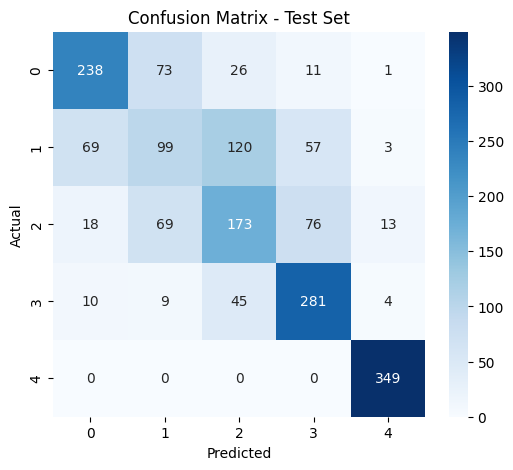

In [164]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 📌 1️⃣ Membagi data menjadi Train (64%), Test (20%), Validation (16%)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=123)

# Inisiasi Model Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# ==== Evaluasi Model Data Validation ====
y_pred_val = nb_model.predict(X_val)
print("\n📊 Evaluasi Model pada Validation Set:")
print(f"📌 Akurasi: {accuracy_score(y_val, y_pred_val):.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))

# Confusion Matrix (Validation Set)
cm_val = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Validation Set")
plt.show()

# === Evaluasi Model Data Test ===
y_pred = nb_model.predict(X_test)
print("\n📊 Evaluasi Model pada Test Set:")
print(f"📌 Akurasi: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix (Test Set)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.show()


## RF


📊 Evaluasi Model pada Validation Set:
📌 Akurasi: 0.9477
📌 F1-Score: 0.9475

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.85      0.88       279
           1       0.87      0.93      0.90       280
           2       0.96      0.96      0.96       279
           3       1.00      1.00      1.00       279
           4       1.00      1.00      1.00       279

    accuracy                           0.95      1396
   macro avg       0.95      0.95      0.95      1396
weighted avg       0.95      0.95      0.95      1396



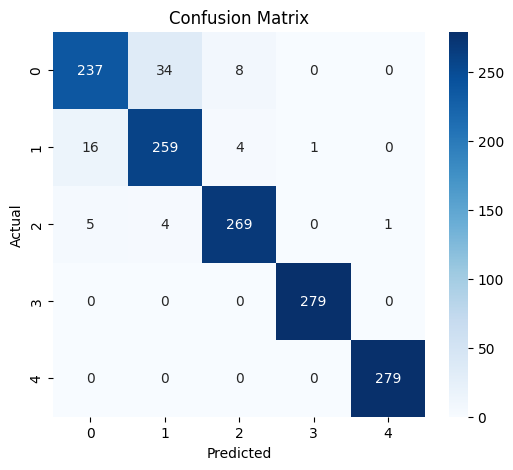


📊 Evaluasi Model pada Test Set:
📌 Akurasi: 0.9467
📌 F1-Score: 0.9461

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.83      0.88       349
           1       0.88      0.93      0.90       348
           2       0.92      0.99      0.95       349
           3       1.00      1.00      1.00       349
           4       1.00      1.00      1.00       349

    accuracy                           0.95      1744
   macro avg       0.95      0.95      0.95      1744
weighted avg       0.95      0.95      0.95      1744



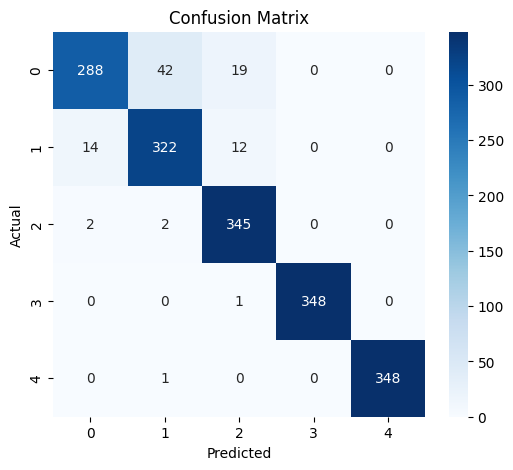

In [165]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# 📌 1️⃣ Membagi data menjadi Train (64%), Test (20%), Validation (16%)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=123)

# Inisiasi Model Random Forest
rf_model = RandomForestClassifier(random_state=123)
rf_model.fit(X_train, y_train)

# ==== Evaluasi Model Data Validation ====
y_pred_val = rf_model.predict(X_val)
print("\n📊 Evaluasi Model pada Validation Set:")
print(f"📌 Akurasi: {accuracy_score(y_val, y_pred_val):.4f}")
print(f"📌 F1-Score: {f1_score(y_val, y_pred_val, average='weighted'):.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))

# Confusion Matrix (Test Set)
cm_val = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# === Evaluasi Model Data Test ===
y_pred = rf_model.predict(X_test)
print("\n📊 Evaluasi Model pada Test Set:")
print(f"📌 Akurasi: {accuracy_score(y_test, y_pred):.4f}")
print(f"📌 F1-Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix (Test Set)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## XGB


📊 Evaluasi Model pada Validation Set:
📌 Akurasi: 0.9477
📌 F1-Score: 0.9476

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90       279
           1       0.90      0.90      0.90       280
           2       0.96      0.95      0.96       279
           3       0.98      1.00      0.99       279
           4       1.00      1.00      1.00       279

    accuracy                           0.95      1396
   macro avg       0.95      0.95      0.95      1396
weighted avg       0.95      0.95      0.95      1396



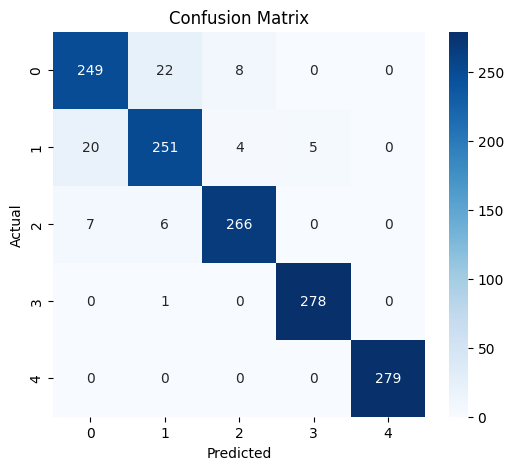


📊 Evaluasi Model pada Test Set:
📌 Akurasi: 0.9427
📌 F1-Score: 0.9425

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89       349
           1       0.89      0.91      0.90       348
           2       0.91      0.97      0.93       349
           3       1.00      0.98      0.99       349
           4       1.00      1.00      1.00       349

    accuracy                           0.94      1744
   macro avg       0.94      0.94      0.94      1744
weighted avg       0.94      0.94      0.94      1744



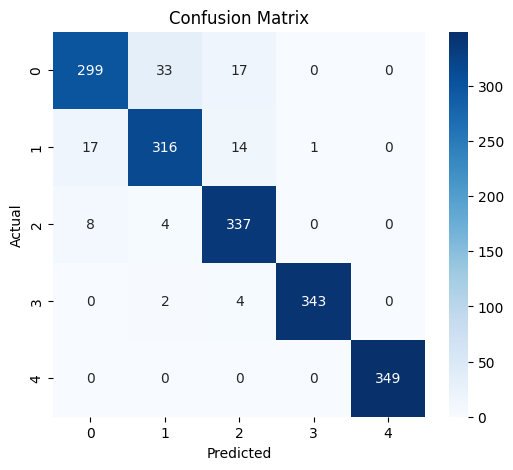

In [166]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import joblib

# Membagi data menjadi Train (64%), Test (20%), Validation (16%)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=123)

# Inisialisasi model XGBoost
xgb_model = XGBClassifier(random_state=123)

# Latih model dengan data hasil SMOTE
xgb_model.fit(X_train, y_train)

# === Evaluasi Model Data Validation ===
y_pred_val = xgb_model.predict(X_val)
print("\n📊 Evaluasi Model pada Validation Set:")
print(f"📌 Akurasi: {accuracy_score(y_val, y_pred_val):.4f}")
print(f"📌 F1-Score: {f1_score(y_val, y_pred_val, average='weighted'):.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))

# Confusion Matrix (Test Set)
cm_val = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# === Evaluasi Model Data Test ====
y_pred = xgb_model.predict(X_test)
print("\n📊 Evaluasi Model pada Test Set:")
print(f"📌 Akurasi: {accuracy_score(y_test, y_pred):.4f}")
print(f"📌 F1-Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix (Test Set)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# Save Model

In [167]:
# Simpan model terbaik
joblib.dump(rf_model, 'best_rf.pkl')
print("\n✅ Model berhasil disimpan sebagai 'best_rf.pkl'")

# Simpan model terbaik
joblib.dump(xgb_model, 'best_xgb.pkl')
print("\n✅ Model berhasil disimpan sebagai 'best_xgb.pkl'")


✅ Model berhasil disimpan sebagai 'best_rf.pkl'

✅ Model berhasil disimpan sebagai 'best_xgb.pkl'


# Data Test

In [168]:
df_pred = df_test.copy()
df_pred 

,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR
0,0.391304,-0.914286,-0.558140,0.681818,1,0.2500,-1.0,0.885714,-1.0,8
1,-0.652174,-0.571429,-1.395349,1.000000,2,0.0000,-1.0,0.942857,-2.0,1
2,-0.130435,0.685714,0.651163,0.318182,0,0.1750,-1.5,0.828571,-1.0,8
3,0.217391,0.228571,0.558140,0.272727,0,0.9375,0.0,0.971429,0.0,8
4,0.130435,0.228571,-0.744186,0.636364,1,0.4750,0.0,0.857143,-1.0,5
...,...,...,...,...,...,...,...,...,...,...
77,0.391304,-0.285714,-0.372093,0.590909,1,0.6625,1.0,0.857143,-1.0,8
78,0.043478,1.257143,1.023256,0.363636,1,0.4375,0.0,0.857143,0.0,8
79,0.565217,0.857143,0.000000,0.454545,0,0.7375,1.5,0.828571,2.0,8
80,-0.652174,-0.228571,-0.093023,0.681818,1,0.8000,0.5,0.914286,1.0,8


In [169]:
df_pred = df_pred.drop(columns=['RR'])

In [170]:
df_pred

,TN,TX,TAVG,RH_AVG,SS,FF_X,DDD_X,FF_AVG,DDD_CAR
0,0.391304,-0.914286,-0.558140,0.681818,0.2500,-1.0,0.885714,-1.0,8
1,-0.652174,-0.571429,-1.395349,1.000000,0.0000,-1.0,0.942857,-2.0,1
2,-0.130435,0.685714,0.651163,0.318182,0.1750,-1.5,0.828571,-1.0,8
3,0.217391,0.228571,0.558140,0.272727,0.9375,0.0,0.971429,0.0,8
4,0.130435,0.228571,-0.744186,0.636364,0.4750,0.0,0.857143,-1.0,5
...,...,...,...,...,...,...,...,...,...
77,0.391304,-0.285714,-0.372093,0.590909,0.6625,1.0,0.857143,-1.0,8
78,0.043478,1.257143,1.023256,0.363636,0.4375,0.0,0.857143,0.0,8
79,0.565217,0.857143,0.000000,0.454545,0.7375,1.5,0.828571,2.0,8
80,-0.652174,-0.228571,-0.093023,0.681818,0.8000,0.5,0.914286,1.0,8


In [171]:
rf_model_loaded = joblib.load('best_rf.pkl')

# Prediksi menggunakan model Random Forest yang dimuat
y_pred_rf_loaded = rf_model_loaded.predict(df_pred)

# Tambahkan hasil prediksi ke DataFrame 'submit'
df_test['RR_new_rf'] = y_pred_rf_loaded

df_test

,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR,RR_new_rf
0,0.391304,-0.914286,-0.558140,0.681818,1,0.2500,-1.0,0.885714,-1.0,8,1
1,-0.652174,-0.571429,-1.395349,1.000000,2,0.0000,-1.0,0.942857,-2.0,1,1
2,-0.130435,0.685714,0.651163,0.318182,0,0.1750,-1.5,0.828571,-1.0,8,0
3,0.217391,0.228571,0.558140,0.272727,0,0.9375,0.0,0.971429,0.0,8,0
4,0.130435,0.228571,-0.744186,0.636364,1,0.4750,0.0,0.857143,-1.0,5,1
...,...,...,...,...,...,...,...,...,...,...,...
77,0.391304,-0.285714,-0.372093,0.590909,1,0.6625,1.0,0.857143,-1.0,8,0
78,0.043478,1.257143,1.023256,0.363636,1,0.4375,0.0,0.857143,0.0,8,0
79,0.565217,0.857143,0.000000,0.454545,0,0.7375,1.5,0.828571,2.0,8,1
80,-0.652174,-0.228571,-0.093023,0.681818,1,0.8000,0.5,0.914286,1.0,8,1


In [172]:
xgb_model_loaded = joblib.load('best_xgb.pkl')

# Prediksi menggunakan model Random Forest yang dimuat
y_pred_xgb_loaded = xgb_model_loaded.predict(df_pred)

# Tambahkan hasil prediksi ke DataFrame 'submit'
df_test['RR_new_xgb'] = y_pred_xgb_loaded

df_test

,TN,TX,TAVG,RH_AVG,RR,SS,FF_X,DDD_X,FF_AVG,DDD_CAR,RR_new_rf,RR_new_xgb
0,0.391304,-0.914286,-0.558140,0.681818,1,0.2500,-1.0,0.885714,-1.0,8,1,1
1,-0.652174,-0.571429,-1.395349,1.000000,2,0.0000,-1.0,0.942857,-2.0,1,1,1
2,-0.130435,0.685714,0.651163,0.318182,0,0.1750,-1.5,0.828571,-1.0,8,0,0
3,0.217391,0.228571,0.558140,0.272727,0,0.9375,0.0,0.971429,0.0,8,0,0
4,0.130435,0.228571,-0.744186,0.636364,1,0.4750,0.0,0.857143,-1.0,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.391304,-0.285714,-0.372093,0.590909,1,0.6625,1.0,0.857143,-1.0,8,0,0
78,0.043478,1.257143,1.023256,0.363636,1,0.4375,0.0,0.857143,0.0,8,0,0
79,0.565217,0.857143,0.000000,0.454545,0,0.7375,1.5,0.828571,2.0,8,1,0
80,-0.652174,-0.228571,-0.093023,0.681818,1,0.8000,0.5,0.914286,1.0,8,1,1


In [173]:
from sklearn.metrics import accuracy_score

accuracy_rf = accuracy_score(df_test['RR'], df_test['RR_new_rf'])
print(f"Akurasi: {accuracy_rf:.4f}")

accuracy_xgb = accuracy_score(df_test['RR'], df_test['RR_new_xgb'])
print(f"Akurasi: {accuracy_xgb:.4f}")


Akurasi: 0.5610
Akurasi: 0.5000
